<a href="https://colab.research.google.com/github/sp7412/udacity/blob/master/fashion-mnist/fashion-mnist-tensorflow-2-0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from seaborn import heatmap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import zipfile
import requests
import io

url = "https://github.com/sp7412/udacity/blob/master/fashion-mnist/minst-fashion-dataset.zip?raw=true"
header = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:32.0) Gecko/20100101 Firefox/54.0.1',}
remotezip = requests.get(url, headers=header)
root = zipfile.ZipFile(io.BytesIO(remotezip.content))

In [0]:
df_train = pd.read_csv(root.open('fashion-mnist_train.csv')) 
df_test = pd.read_csv(root.open('fashion-mnist_test.csv')) 

In [0]:
df_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


In [0]:
train_label = df_train['label']
test_label = df_test['label']

df_test = df_test.drop(columns = ['label'])
df_train = df_train.drop(columns = ['label'])

X_train, X_val, y_train, y_val = train_test_split(df_train, train_label, test_size = .3, stratify = train_label)

X_train = (X_train/255).values.reshape(len(X_train), 28,28,1)
X_val = (X_val/255).values.reshape(len(X_val), 28,28, 1)
X_test = (df_test/255).values.reshape(len(df_test), 28,28, 1)

In [0]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(42000, 28, 28, 1)
(18000, 28, 28, 1)
(10000, 28, 28, 1)


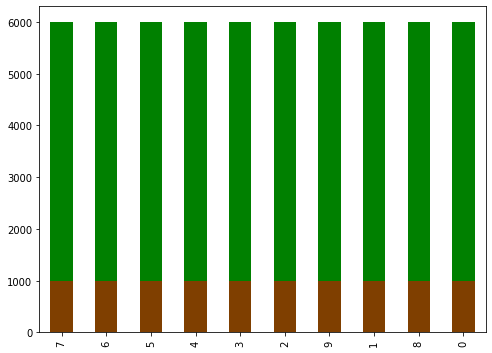

In [0]:
plt.figure(figsize = (8,6))
train_label.value_counts().plot(kind = 'bar', color = 'green')
test_label.value_counts().plot(kind = 'bar', color = 'red', alpha = .5)

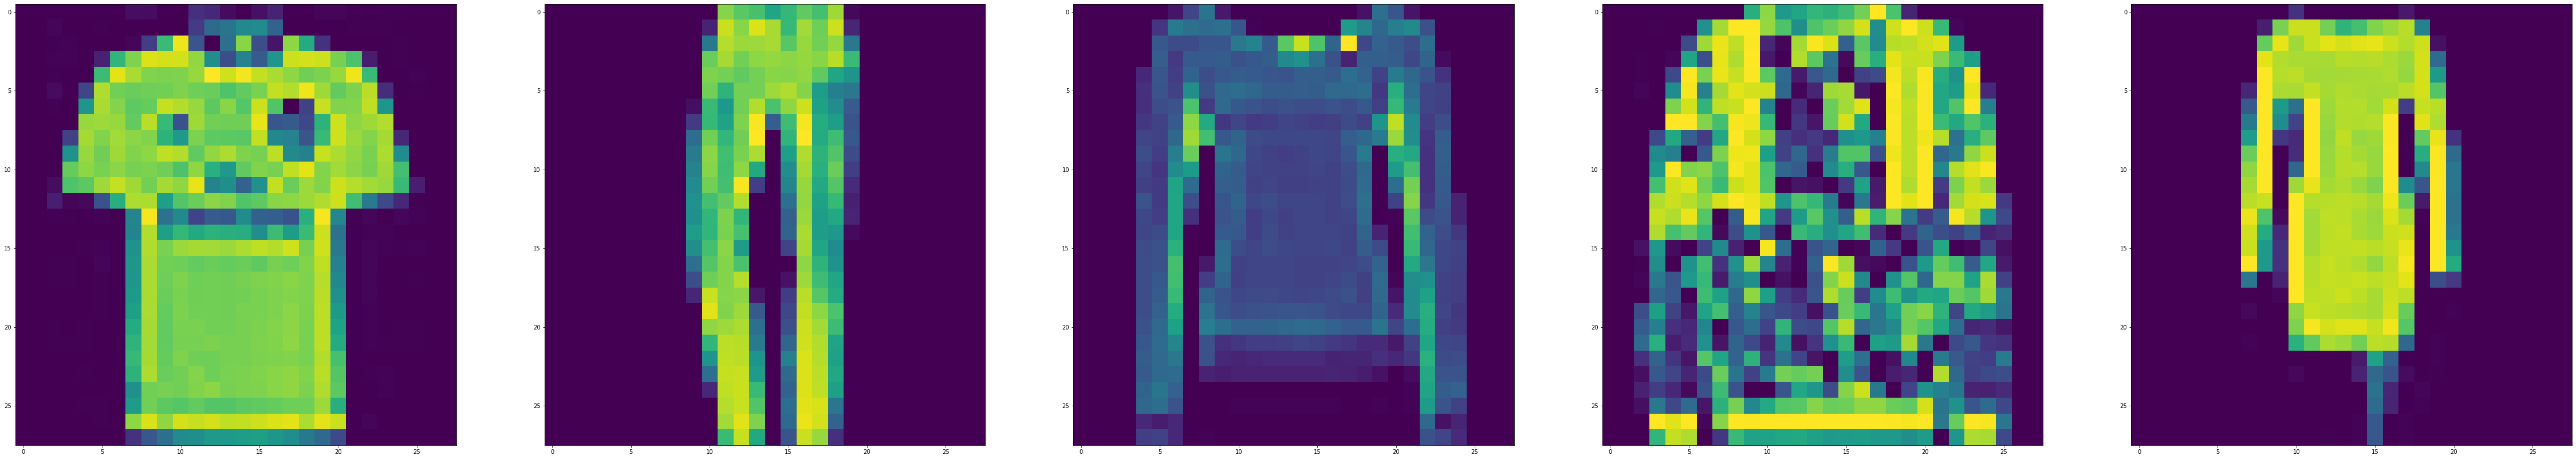

In [0]:
#plt.imshow(df_test.iloc[0, ""].values.reshape((28,28)))
#plt.imshow(df_test.iloc[1, :].values.reshape((28,28)))
#plt.imshow(df_test.iloc[2, :].values.reshape((28,28)))

f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(df_test.iloc[i, :].values.reshape(28, 28))
plt.show()

In [0]:
def Model():
    
    model = Sequential()

    #CCN1
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'relu', input_shape = (28,28, 1)))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (28,28, 1)))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'relu', input_shape = (28,28, 1)))
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(Dropout(.3))

    #CCN2
    model.add(Conv2D(filters = 128, padding = 'same', kernel_size = (2,2), activation = 'relu'))
    model.add(Conv2D(filters = 128, padding = 'same',kernel_size = (2,2), activation = 'relu'))
    model.add(Conv2D(filters = 128, padding = 'same',kernel_size = (2,2), activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(Dropout(.25))

    #CCN3
    model.add(Conv2D(filters = 256, padding = 'same',kernel_size = (2,2), activation = 'relu'))
    model.add(Conv2D(filters = 256, padding = 'same',kernel_size = (2,2), activation = 'relu'))
    model.add(Conv2D(filters = 256, padding = 'same', kernel_size = (2,2), activation = 'relu'))
    
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(Dropout(.25))
    
      #CCN3
    #model.add(Conv2D(filters = 512, kernel_size = (2,2), activation = 'relu'))
    #model.add(MaxPool2D(pool_size = (2,2)))
    #model.add(Dropout(.25))


    #Flatten
    model.add(Flatten())

    # Dense1
    model.add(Dense(1024,  activation = 'relu'))
    model.add(Dense(1024,  activation = 'relu'))
    model.add(Dropout(.2))

    # Dense2
    model.add(Dense(512,  activation = 'relu'))
    model.add(Dense(512,  activation = 'relu'))
    model.add(Dropout(.3))

    # Dense3
    model.add(Dense(128,  activation = 'relu'))
    model.add(Dropout(.3))

    # Dense4
    model.add(Dense(64,  activation = 'relu'))
    model.add(Dropout(.3))

    # Outpot
    model.add(Dense(10,  activation = 'softmax'))
    model.compile(optimizer = Adam(lr = .001), loss = sparse_categorical_crossentropy, metrics = ['accuracy'])
    
    return model

def Model():
    from tensorflow.keras import models
    from tensorflow.keras import layers
    RESCALE_HEIGHT = 256
    RESCALE_WIDTH = 256
    # Build the model
    model = models.Sequential()
    # From O'Shea, Roy, Erpek "Spectral Detection and Localization of Radio Events with Learned
    # Convolutional Neural Features". EUSIPCO 2017
    # Layer 1 
    model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape=(RESCALE_HEIGHT,RESCALE_WIDTH,1)))
    # The paper specifies Dropout(0.5) for each convolutional layer -- but is this really 
    # a good thing to do?
    #model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling2D((2,2)))
    # Layer 2
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    #model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling2D((2,2)))
    # Layer 3 
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    #model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling2D((2,2)))
    # Layer 4 
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    #model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    #model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    #model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling2D((2,2)))

    # Layer 5 
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))
    # Layer 6
    # Size should be equal to the number of classes
    model.add(layers.Dense(10,activation='softmax',name='scores'))

    # Compile the model
    # Paper specifies ADAM optimizer and  Categorical Cross-Entropy loss function
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    return model


In [34]:
model = Model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 254, 254, 64)      640       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 64)       

In [35]:
batch_size = 32

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', verbose = 0)
model_save =  ModelCheckpoint('model_weights.hdf5' , monitor = 'val_loss', save_best_only = True, mode = 'min')
reduce_lr =  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

history = model.fit(X_train, y_train, callbacks=[early_stopping, model_save, reduce_lr], 
          batch_size =batch_size, epochs = 50, validation_data = (X_val, y_val), verbose = 1  )


Epoch 1/50


ValueError: ignored

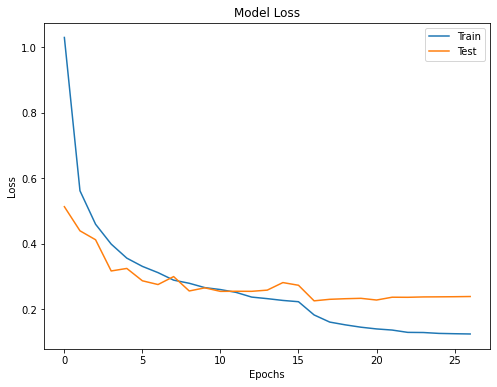

In [0]:
plt.figure(figsize = (8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

In [0]:
score_train = model.evaluate(X_train, y_train)
score_val = model.evaluate(X_val, y_val)

563/563 [==============================] - 2s 4ms/step - loss: 0.2395 - accuracy: 0.9277


In [0]:
print("Loss Train : {}  and  Accuracy Train : {}".format(score_train[0], score_train[1]))
print("Loss validate : {}  and  Accuracy Validate : {}".format(score_val[0], score_val[1]))

Loss Train : 0.08834496140480042  and  Accuracy Train : 0.9668571352958679
Loss validate : 0.23948301374912262  and  Accuracy Validate : 0.9276666641235352


In [0]:
y_predict = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [0]:
y_predict

array([0, 1, 2, ..., 8, 8, 1])

In [0]:
CM = confusion_matrix(y_predict, test_label)
print(CM)

[[884   1  11  13   0   0 104   0   1   0]
 [  2 994   0   4   2   0   1   0   1   0]
 [ 21   0 893   2  23   0  40   0   2   0]
 [ 15   4  10 951  18   0  28   0   2   0]
 [  1   0  46  20 923   0  54   0   1   0]
 [  2   0   0   0   0 980   0   4   3   4]
 [ 71   1  37   9  34   0 768   0   3   0]
 [  0   0   0   0   0  14   0 974   0  22]
 [  4   0   3   1   0   1   5   0 986   2]
 [  0   0   0   0   0   5   0  22   1 972]]


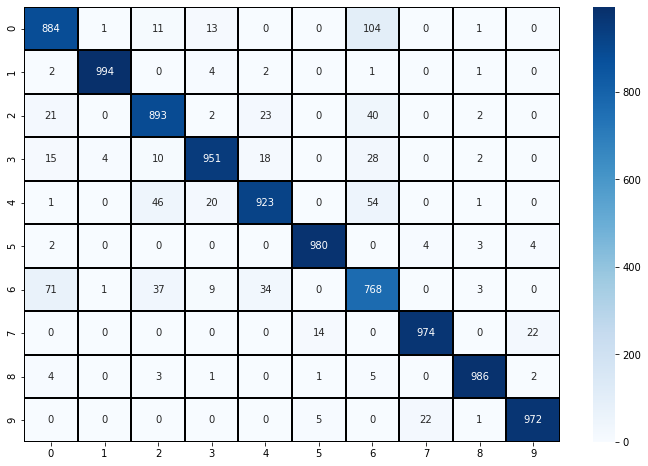

In [0]:
plt.figure(figsize = (12,8))
heatmap(CM, annot = True, cmap=plt.cm.Blues, fmt="d", linecolor ='black',  linewidths=1)

In [0]:
print("Prediction Accuracy:" )
print(accuracy_score(y_predict, test_label))

Prediction Accuracy:
0.9325
